# Analysis of Classified Government Repositories

## Automatic data analysis 

This notebook analyzes the `classified_gov_repositories.csv` file generated by the IAI project. 
The analysis includes:
1. Loading and initial exploration of the data.
2. Frequency analysis of key categorical features (topics, languages, accounts).
3. Text-based clustering of repository summaries to identify thematic groups.

## 1. Setup and Load Data

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re

# Download stopwords if not already present (run once)
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

stop_words = list(stopwords.words('english'))

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [12]:
!pwd

/home/theo/projects/iai/notebooks


In [13]:
# Define the path to the data file
# Assuming the notebook is in 'notebooks/' and data is in 'data/' relative to project root
data_file_path = "../data/20250624_223620_a910a8e1/classified_gov_repositories_batch.csv"

try:
    df = pd.read_csv(data_file_path)
    print(f"Successfully loaded data from {data_file_path}")
except FileNotFoundError:
    print(f"Error: File not found at {data_file_path}. Please check the path.")
    df = pd.DataFrame() # Create an empty DataFrame to avoid further errors

if not df.empty:
    print(f"\nDataset shape: {df.shape}")

Successfully loaded data from ../data/20250624_223620_a910a8e1/classified_gov_repositories_batch.csv

Dataset shape: (16909, 14)


## 2. Initial Data Exploration

In [14]:
if not df.empty:
    print("First 5 rows of the dataset:")
    display(df.head())
    
    print("\nDataset info:")
    df.info()
    
    print("\nSummary statistics for numerical columns:")
    display(df.describe())
    
    print("\nMissing values per column:")
    display(df.isnull().sum())

First 5 rows of the dataset:


,account,name,description,stars,forks,language,url,readme,last_scanned_utc,created_at,pushed_at,summary,embedding,topic
0,NationalSecurityAgency,ghidra,Ghidra is a software reverse engineering (SRE)...,58059,6488,Java,https://github.com/NationalSecurityAgency/ghidra,"<img src=""Ghidra/Features/Base/src/main/resour...",2025-06-24T22:14:40.925653Z,2019-03-01T03:27:48Z,2025-06-24T19:57:07Z,Ghidra is a software reverse engineering (SRE)...,"[-0.008923729881644249, -0.015317474491894245,...",Ghidra Extensions
1,opencti-platform,opencti,Open Cyber Threat Intelligence Platform,7429,1065,TypeScript,https://github.com/OpenCTI-Platform/opencti,"<h1 align=""center"">\n <a href=""https://openct...",2025-06-26T23:03:03.492890Z,2018-12-17T22:57:34Z,2025-06-26T18:38:55Z,OpenCTI is an open-source platform for cyber t...,"[0.009715257212519646, 0.000737666676286608, -...",Uncategorized
2,uswds,uswds,The U.S. Web Design System helps the federal g...,6954,1040,SCSS,https://github.com/uswds/uswds,# United States Web Design System\n\n[![Circle...,2025-06-24T21:37:57.370169Z,2015-05-20T19:10:10Z,2025-06-24T20:08:39Z,The United States Web Design System (USWDS) pr...,"[0.014116269536316395, -0.006521186791360378, ...",USWDS Resources
3,uswds,public-sans,"A strong, neutral, principles-driven, open sou...",4548,116,HTML,https://github.com/uswds/public-sans,# Public Sans\n\nCurrent font files for the Pu...,2025-06-24T21:37:56.807430Z,2016-11-04T13:51:35Z,2025-06-16T17:27:31Z,"Public Sans is a free, open-source typeface de...","[0.016835737973451614, 0.0267143864184618, -0....",Uncategorized
4,pcm-dpc,COVID-19,COVID-19 Italia - Monitoraggio situazione,3833,2224,None specified,https://github.com/pcm-dpc/COVID-19,"<img src=""assets/img/dpc-logo-covid19.png"" alt...",2025-06-27T09:22:43.772424Z,2020-03-07T12:42:02Z,2025-01-10T13:00:45Z,This repository provides data on the COVID-19 ...,"[-0.020156193524599075, 0.00698246480897069, -...",COVID-19 Data



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16909 entries, 0 to 16908
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   account           16909 non-null  object
 1   name              16909 non-null  object
 2   description       16909 non-null  object
 3   stars             16909 non-null  int64 
 4   forks             16909 non-null  int64 
 5   language          16909 non-null  object
 6   url               16909 non-null  object
 7   readme            16840 non-null  object
 8   last_scanned_utc  16909 non-null  object
 9   created_at        16909 non-null  object
 10  pushed_at         16909 non-null  object
 11  summary           16909 non-null  object
 12  embedding         16909 non-null  object
 13  topic             16909 non-null  object
dtypes: int64(2), object(12)
memory usage: 1.8+ MB

Summary statistics for numerical columns:


,stars,forks
count,16909.000000,16909.000000
mean,12.453072,4.078242
std,461.106050,57.134982
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,2.000000
max,58059.000000,6488.000000



Missing values per column:


account              0
name                 0
description          0
stars                0
forks                0
language             0
url                  0
readme              69
last_scanned_utc     0
created_at           0
pushed_at            0
summary              0
embedding            0
topic                0
dtype: int64

Handle missing values if necessary. For text columns used in clustering, fill NaNs with empty strings.

In [15]:
if not df.empty:
    # Fill NaN in 'description', 'readme', 'summary', 'topic' for robust processing
    for col in ['description', 'readme', 'summary', 'topic']:
        if col in df.columns:
            df[col] = df[col].fillna('')
    
    # 'language' can be filled with 'Unknown' or similar
    if 'language' in df.columns:
        df['language'] = df['language'].fillna('Unknown')
        
    print("\nMissing values after handling:")
    display(df.isnull().sum())

    # The next cell will drop 'Uncategorized' topics.


Missing values after handling:


account             0
name                0
description         0
stars               0
forks               0
language            0
url                 0
readme              0
last_scanned_utc    0
created_at          0
pushed_at           0
summary             0
embedding           0
topic               0
dtype: int64

In [16]:
if not df.empty and 'topic' in df.columns:
    print(f"Original shape: {df.shape}")
    
    # Drop rows where the topic is 'Uncategorized'
    df = df[df['topic'] != 'Uncategorized'].copy()
    
    print(f"Shape after dropping 'Uncategorized' topics: {df.shape}")
else:
    print("DataFrame is empty or 'topic' column is missing, skipping drop.")

Original shape: (16909, 14)
Shape after dropping 'Uncategorized' topics: (4523, 14)


## 3. Frequency Analysis

### 3.1. Frequency of Repository Topics

/tmp/ipykernel_49611/3326619396.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.values, y=topic_counts.index, palette='viridis')


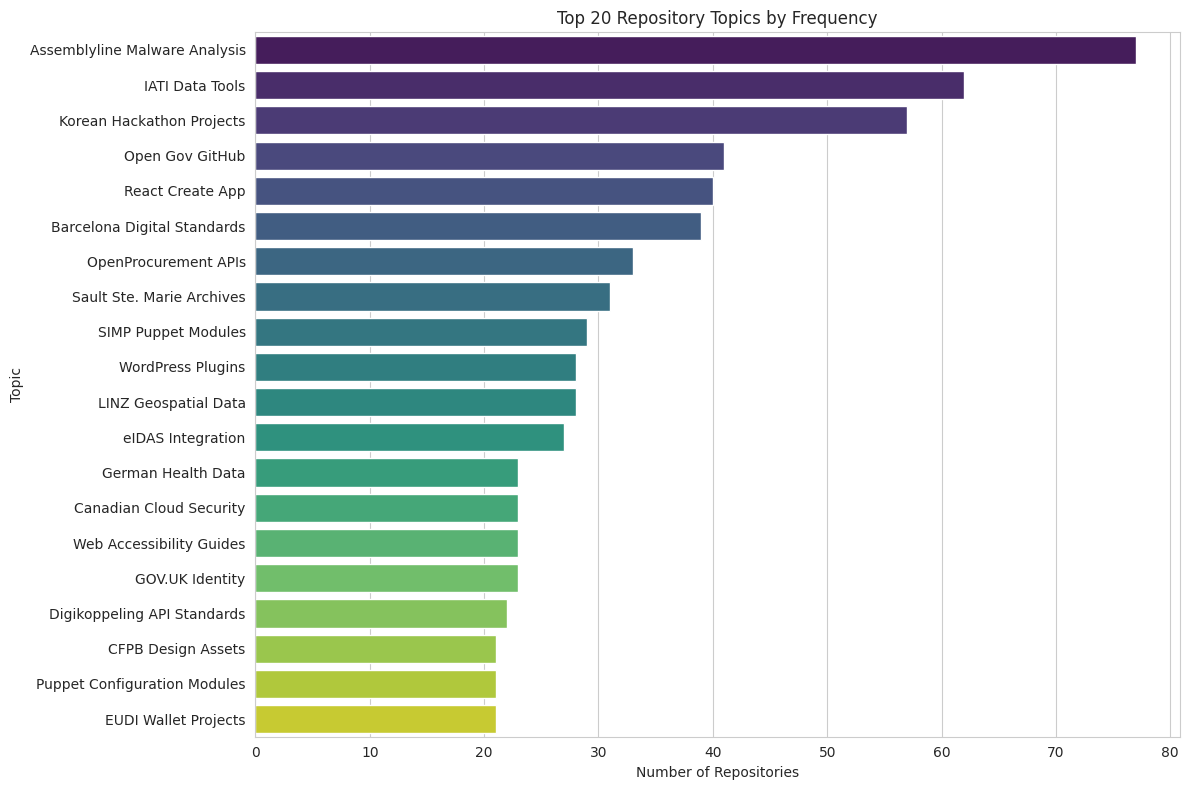


Topic Counts (Top 20):


topic
Assemblyline Malware Analysis    77
IATI Data Tools                  62
Korean Hackathon Projects        57
Open Gov GitHub                  41
React Create App                 40
Barcelona Digital Standards      39
OpenProcurement APIs             33
Sault Ste. Marie Archives        31
SIMP Puppet Modules              29
WordPress Plugins                28
LINZ Geospatial Data             28
eIDAS Integration                27
German Health Data               23
Canadian Cloud Security          23
Web Accessibility Guides         23
GOV.UK Identity                  23
Digikoppeling API Standards      22
CFPB Design Assets               21
Puppet Configuration Modules     21
EUDI Wallet Projects             21
Name: count, dtype: int64

In [17]:
if not df.empty and 'topic' in df.columns:
    plt.figure(figsize=(12, 8))
    topic_counts = df['topic'].value_counts().nlargest(20) # Show top 20 topics
    sns.barplot(x=topic_counts.values, y=topic_counts.index, palette='viridis')
    plt.title('Top 20 Repository Topics by Frequency')
    plt.xlabel('Number of Repositories')
    plt.ylabel('Topic')
    plt.tight_layout()
    plt.show()
    
    print("\nTopic Counts (Top 20):")
    display(topic_counts)
else:
    print("DataFrame is empty or 'topic' column is missing.")

### 3.2. Frequency of Programming Languages

/tmp/ipykernel_49611/1881635305.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_counts.values, y=language_counts.index, palette='mako')


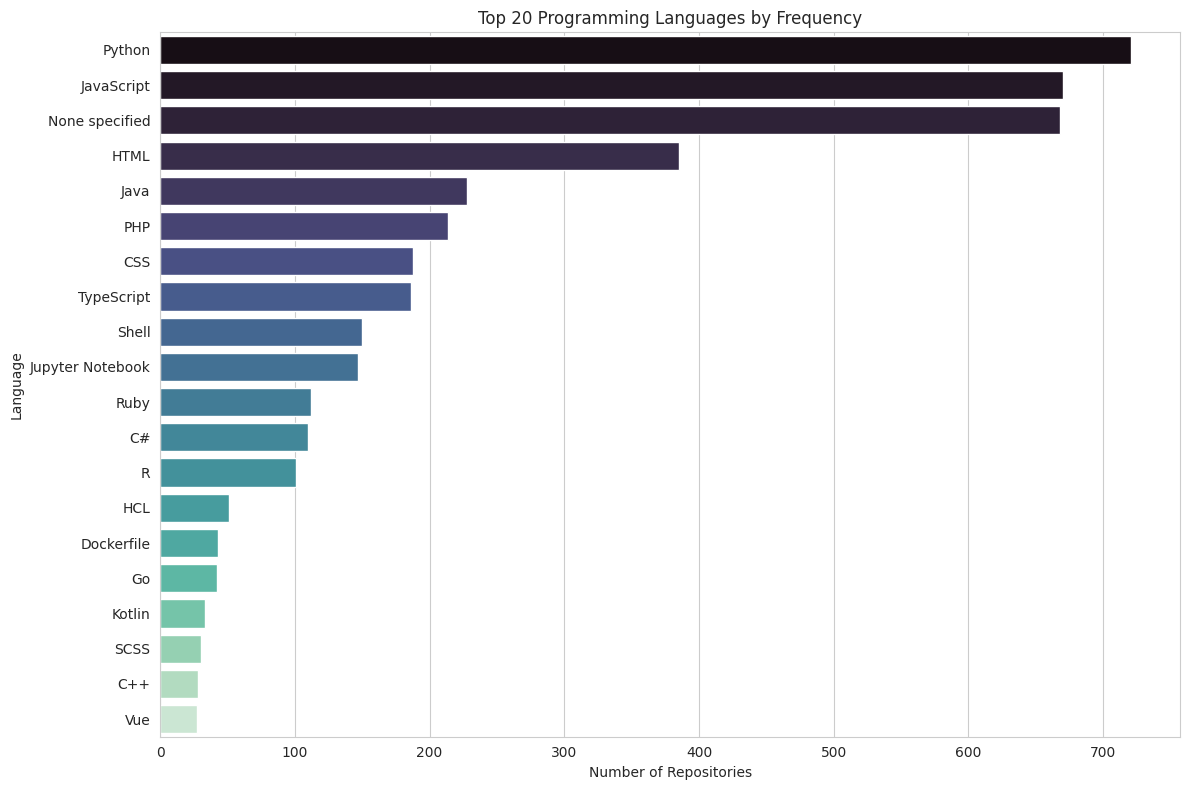


Language Counts (Top 20):


language
Python              721
JavaScript          670
None specified      668
HTML                385
Java                228
PHP                 214
CSS                 188
TypeScript          186
Shell               150
Jupyter Notebook    147
Ruby                112
C#                  110
R                   101
HCL                  51
Dockerfile           43
Go                   42
Kotlin               33
SCSS                 30
C++                  28
Vue                  27
Name: count, dtype: int64

In [18]:
if not df.empty and 'language' in df.columns:
    plt.figure(figsize=(12, 8))
    language_counts = df['language'].value_counts().nlargest(20) # Show top 20 languages
    sns.barplot(x=language_counts.values, y=language_counts.index, palette='mako')
    plt.title('Top 20 Programming Languages by Frequency')
    plt.xlabel('Number of Repositories')
    plt.ylabel('Language')
    plt.tight_layout()
    plt.show()
    
    print("\nLanguage Counts (Top 20):")
    display(language_counts)
else:
    print("DataFrame is empty or 'language' column is missing.")

### 3.3. Frequency of Government Accounts

/tmp/ipykernel_149702/3365368763.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=account_counts.values, y=account_counts.index, palette='rocket')


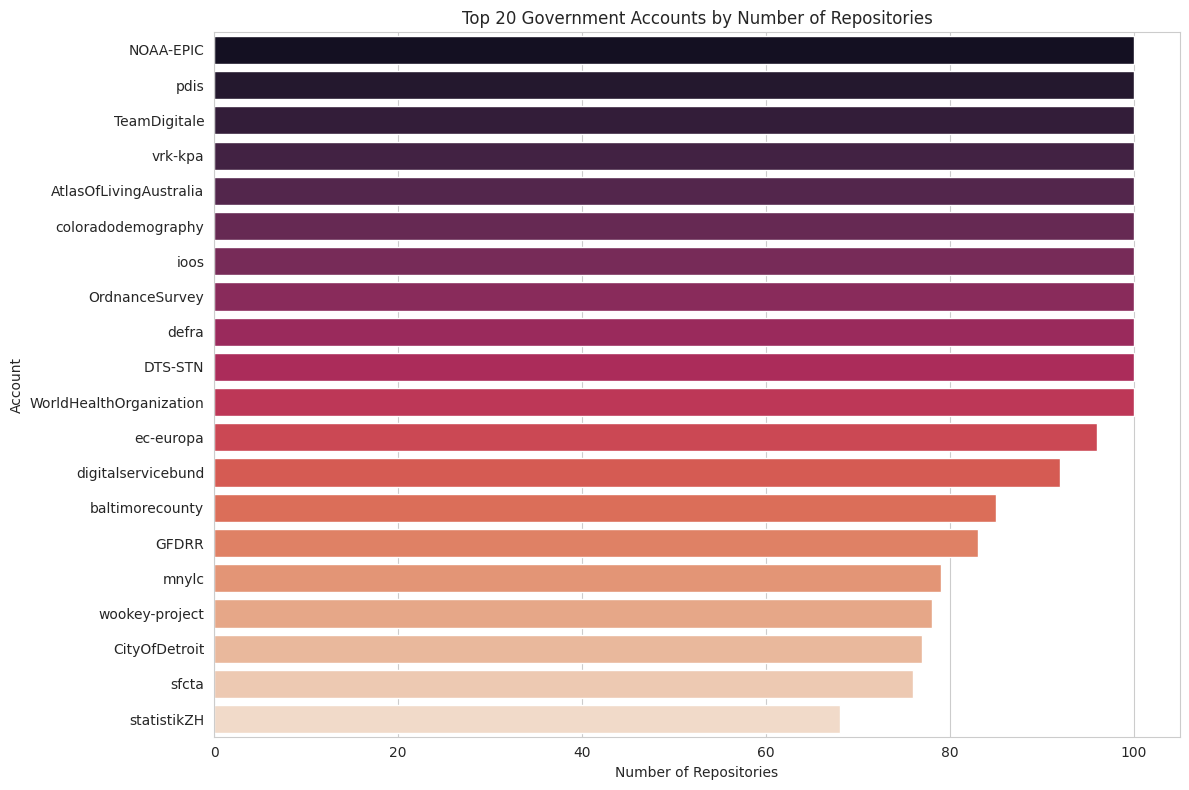


Account Counts (Top 20):


account
NOAA-EPIC                  100
pdis                       100
TeamDigitale               100
vrk-kpa                    100
AtlasOfLivingAustralia     100
coloradodemography         100
ioos                       100
OrdnanceSurvey             100
defra                      100
DTS-STN                    100
WorldHealthOrganization    100
ec-europa                   96
digitalservicebund          92
baltimorecounty             85
GFDRR                       83
mnylc                       79
wookey-project              78
CityOfDetroit               77
sfcta                       76
statistikZH                 68
Name: count, dtype: int64

In [10]:
if not df.empty and 'account' in df.columns:
    plt.figure(figsize=(12, 8))
    account_counts = df['account'].value_counts().nlargest(20) # Show top 20 accounts
    sns.barplot(x=account_counts.values, y=account_counts.index, palette='rocket')
    plt.title('Top 20 Government Accounts by Number of Repositories')
    plt.xlabel('Number of Repositories')
    plt.ylabel('Account')
    plt.tight_layout()
    plt.show()
    
    print("\nAccount Counts (Top 20):")
    display(account_counts)
else:
    print("DataFrame is empty or 'account' column is missing.")

## 4. Text Clustering of Repository Summaries

We will use the 'summary' column for clustering. First, we need to preprocess the text and vectorize it using TF-IDF.

In [12]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\W', ' ', text) # Remove special characters
    text = re.sub(r'\s+', ' ', text) # Remove multiple spaces
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2] # Remove stopwords and short words
    return " ".join(words)

if not df.empty and 'summary' in df.columns:
    # Ensure 'summary' column exists and is not empty
    if df['summary'].isnull().all() or (df['summary'] == '').all():
        print("Warning: 'summary' column is empty or all NaN. Clustering cannot proceed.")
        summaries_for_clustering = pd.Series([])
    else:
        df['processed_summary'] = df['summary'].apply(preprocess_text)
        summaries_for_clustering = df['processed_summary'][df['processed_summary'].str.strip() != '']
        
        if summaries_for_clustering.empty:
            print("Warning: No valid summaries available after preprocessing. Clustering cannot proceed.")
        else:
            print(f"{len(summaries_for_clustering)} summaries available for clustering after preprocessing.")
            display(summaries_for_clustering.head())
else:
    print("DataFrame is empty or 'summary' column is missing.")
    summaries_for_clustering = pd.Series([]) # Define to avoid errors later

218 summaries available for clustering after preprocessing.


0    web design system uswds provides open source l...
1    public sans free open source typeface designed...
2    miasm reverse engineering framework enabling a...
3    repository contains covid app built using flut...
4    sibyl dynamic analysis tool using miasm2 ident...
Name: processed_summary, dtype: object

In [13]:
if not summaries_for_clustering.empty:
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.95,  # ignore terms that appear in more than 95% of documents
        min_df=2,     # ignore terms that appear in less than 2 documents
        max_features=1000 # consider only top 1000 features
    )
    tfidf_matrix = tfidf_vectorizer.fit_transform(summaries_for_clustering)
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
else:
    print("Skipping TF-IDF vectorization as no valid summaries are available.")
    tfidf_matrix = None

TF-IDF matrix shape: (218, 1000)


### 4.1. Determine Optimal Number of Clusters (Elbow Method)

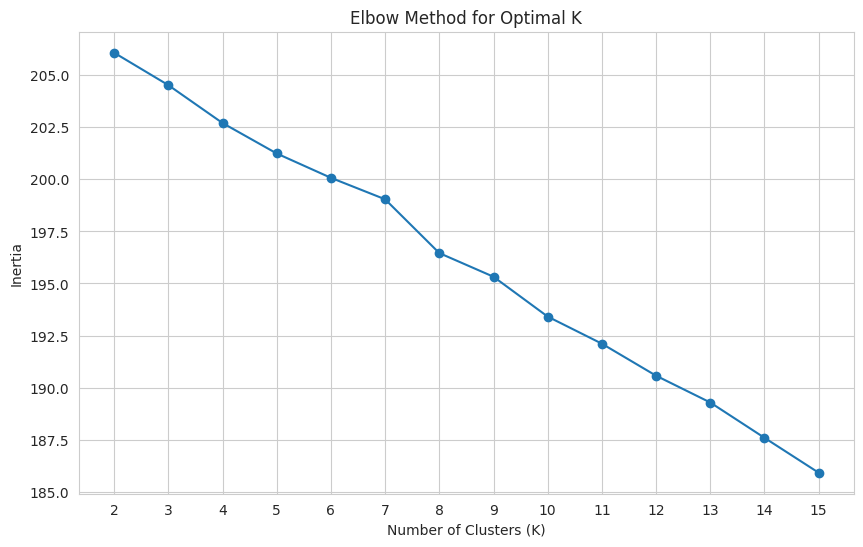

Suggested optimal K based on elbow heuristic: 8


In [14]:
if tfidf_matrix is not None and tfidf_matrix.shape[0] > 1: # Need at least 2 samples for clustering
    inertia = []
    # Consider a range of K. If dataset is small, K_range might need adjustment.
    max_k = min(15, tfidf_matrix.shape[0]) # Max K is 15 or num_samples
    if max_k <= 1:
        print("Not enough samples to perform K-Means clustering for a range of K.")
    else:
        k_range = range(2, max_k + 1)
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            kmeans.fit(tfidf_matrix)
            inertia.append(kmeans.inertia_)
        
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertia, marker='o')
        plt.title('Elbow Method for Optimal K')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Inertia')
        plt.xticks(k_range)
        plt.show()
        
        # Suggest an optimal K based on the elbow (heuristic)
        # This is a simple heuristic, visual inspection is often better.
        if len(inertia) > 1:
            # Calculate differences between consecutive inertia values
            diffs = np.diff(inertia)
            # Calculate differences of these differences (second derivative)
            diffs2 = np.diff(diffs)
            # The elbow is where the second derivative is maximized (most change in slope)
            # Add 2 to k_range index because k_range starts at 2 and diffs2 index is 0-based for k_range[2]
            if len(diffs2) > 0:
                optimal_k_elbow = k_range[np.argmax(diffs2) + 1] if len(diffs2) > 0 else k_range[0]
                print(f"Suggested optimal K based on elbow heuristic: {optimal_k_elbow}")
            else:
                optimal_k_elbow = k_range[0] # Default to smallest K if not enough points for 2nd derivative
                print(f"Could not determine optimal K via heuristic, defaulting to K={optimal_k_elbow}. Please inspect the plot.")
        else:
            optimal_k_elbow = 2 # Default if only one point in inertia
            print(f"Not enough data points for elbow heuristic, defaulting to K={optimal_k_elbow}. Please inspect the plot.")
else:
    print("Skipping Elbow method as TF-IDF matrix is not available or has too few samples.")
    optimal_k_elbow = 0 # Indicates clustering cannot proceed

### 4.2. Apply K-Means Clustering

In [17]:
# Choose a K based on the elbow plot or a fixed number if the plot is unclear
# For this example, let's use the suggested optimal_k_elbow if valid, or a default like 5.
CHOSEN_K = 0
if 'optimal_k_elbow' in locals() and optimal_k_elbow > 1:
    CHOSEN_K = optimal_k_elbow
elif tfidf_matrix is not None and tfidf_matrix.shape[0] >= 5: # Ensure enough samples for K=5
    CHOSEN_K = 5
    print(f"Elbow method did not yield a clear K or was skipped. Using default K={CHOSEN_K}.")
else:
    print("Not enough samples for clustering or TF-IDF matrix not available. Skipping K-Means.")

cluster_labels = None
if CHOSEN_K > 1 and tfidf_matrix is not None and tfidf_matrix.shape[0] >= CHOSEN_K:
    kmeans = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    
    # Add cluster labels back to the DataFrame (for the subset that had valid summaries)
    # Ensure indices align if summaries_for_clustering was a subset of df
    df_clustered = df.loc[summaries_for_clustering.index].copy() # Work on a copy
    df_clustered['text_cluster'] = cluster_labels
    
    print(f"\nRepositories assigned to {CHOSEN_K} clusters.")
    print("Cluster distribution:")
    display(df_clustered['text_cluster'].value_counts().sort_index())
    
    # Merge cluster labels back into the original df, if desired
    df['text_cluster'] = pd.NA # Initialize with NA
    if 'df_clustered' in locals():
        df.loc[df_clustered.index, 'text_cluster'] = df_clustered['text_cluster']
else:
    print(f"Skipping K-Means clustering. CHOSEN_K={CHOSEN_K}, tfidf_matrix available: {tfidf_matrix is not None}")


Repositories assigned to 8 clusters.
Cluster distribution:


text_cluster
0    30
1    39
2    45
3    10
4    23
5    24
6    23
7    24
Name: count, dtype: int64

### 4.3. Analyze Clusters - Top Terms

In [18]:
if 'kmeans' in locals() and kmeans is not None and 'tfidf_vectorizer' in locals() and tfidf_vectorizer is not None and CHOSEN_K > 1:
    print(f"Top terms per cluster (K={CHOSEN_K}):")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    for i in range(CHOSEN_K):
        print(f"Cluster {i}:", end='')
        for ind in order_centroids[i, :10]: # Top 10 terms
            print(f' {terms[ind]}', end=',')
        print("\n")
else:
    print("Skipping top terms analysis as clustering was not performed or models are not available.")

Top terms per cluster (K=8):
Cluster 0: development, catalog, offers, repository, using, provides, apis, includes, tools, data,

Cluster 1: data, repository, access, information, provides, risk, resources, package, facilitates, ioos,

Cluster 2: uswds, components, design, system, repository, development, via, provides, websites, npm,

Cluster 3: network, stylesheets, software, styles, maps, repository, cartographic, gnss, tokens, boundary,

Cluster 4: digital, repository, covid, implementation, guide, health, tracking, management, facilitates, app,

Cluster 5: api, tools, data, scripts, json, repository, also, includes, provides, files,

Cluster 6: repository, website, new, static, content, site, materials, contains, gov, project,

Cluster 7: application, web, data, project, users, tax, allows, service, time, information,



### 4.4. Visualize Clusters (PCA)

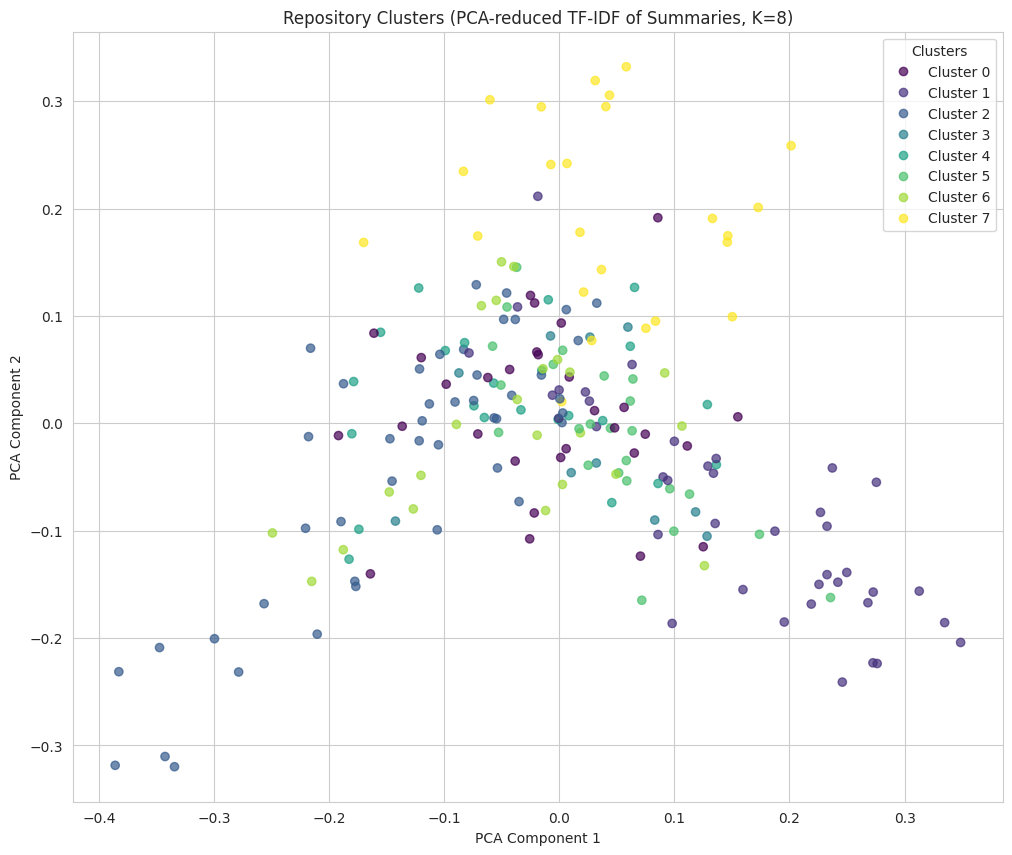

In [19]:
if cluster_labels is not None and tfidf_matrix is not None and tfidf_matrix.shape[0] > 1 and tfidf_matrix.shape[1] > 1:
    # Reduce dimensionality using PCA
    # Ensure n_components is less than min(n_samples, n_features)
    n_components_pca = min(2, tfidf_matrix.shape[0], tfidf_matrix.shape[1])
    if n_components_pca < 2:
        print("Cannot perform PCA with less than 2 components. Skipping visualization.")
    else:
        pca = PCA(n_components=n_components_pca, random_state=42)
        # K-means works with sparse matrices, but PCA in scikit-learn typically expects dense arrays.
        # If tfidf_matrix is very large, .toarray() can cause memory issues.
        # Consider TruncatedSVD for sparse data if memory is a concern.
        try:
            reduced_features = pca.fit_transform(tfidf_matrix.toarray())
            
            plt.figure(figsize=(12, 10))
            scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
            plt.title(f'Repository Clusters (PCA-reduced TF-IDF of Summaries, K={CHOSEN_K})')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            
            # Create a legend
            if CHOSEN_K <= 10: # Only show legend if K is not too large
                legend_elements = scatter.legend_elements()
                plt.legend(handles=legend_elements[0], labels=[f'Cluster {i}' for i in range(CHOSEN_K)], title="Clusters")
            plt.show()
        except MemoryError:
            print("MemoryError: TF-IDF matrix is too large to convert to dense array for PCA. Consider using TruncatedSVD or sampling.")
        except Exception as e:
            print(f"An error occurred during PCA or plotting: {e}")
else:
    print("Skipping cluster visualization as cluster labels or TF-IDF matrix are not available or insufficient data.")

### 4.5. Explore Clusters with Original Topics

In [20]:
if 'df_clustered' in locals() and 'text_cluster' in df_clustered.columns and 'topic' in df_clustered.columns:
    print("\nDistribution of original 'topic' labels within each new text_cluster:")
    for i in range(CHOSEN_K):
        print(f"\n--- Cluster {i} --- Top Original Topics ---")
        cluster_data = df_clustered[df_clustered['text_cluster'] == i]
        if not cluster_data.empty:
            topic_distribution = cluster_data['topic'].value_counts().nlargest(5)
            if not topic_distribution.empty:
                display(topic_distribution)
            else:
                print("No topics found or topic column was empty for this cluster.")
            
            # Show a few example summaries from this cluster
            print("\nExample summaries from this cluster:")
            # Ensure 'summary' column exists in df_clustered
            if 'summary' in cluster_data.columns:
                display(cluster_data[['name', 'summary']].head(3))
            else:
                display(cluster_data[['name']].head(3)) # Fallback if summary is not there
        else:
            print("No data in this cluster.")
else:
    print("Skipping analysis of original topics within text clusters as clustering data is not fully available.")

Skipping analysis of original topics within text clusters as clustering data is not fully available.


## 5. Further Analysis Ideas

- **Correlation Analysis**: Explore correlations between numerical features (stars, forks) and categorical features (e.g., average stars per topic/language).
- **Time Series Analysis**: If repository creation/update dates were available, analyze trends over time.
- **Network Analysis**: If user/organization collaboration data were available, build and analyze a collaboration network.
- **Sentiment Analysis**: Perform sentiment analysis on READMEs or descriptions.
- **Advanced Clustering**: Use more sophisticated clustering algorithms like DBSCAN or hierarchical clustering.
- **Topic Modeling (LDA)**: Apply Latent Dirichlet Allocation on READMEs/descriptions to discover underlying topics in a more unsupervised way than the pre-assigned 'topic' column.

## 6. Conclusion

In [21]:
if not df.empty:
    print("Analysis complete. Key insights:")
    if 'topic_counts' in locals():
        print(f"- Most frequent repository topic: {topic_counts.index[0] if not topic_counts.empty else 'N/A'} ({topic_counts.iloc[0] if not topic_counts.empty else 0} repositories)")
    if 'language_counts' in locals():
        print(f"- Most frequent programming language: {language_counts.index[0] if not language_counts.empty else 'N/A'} ({language_counts.iloc[0] if not language_counts.empty else 0} repositories)")
    if cluster_labels is not None and CHOSEN_K > 1:
        print(f"- Repositories were grouped into {CHOSEN_K} clusters based on their summaries.")
        print("- Review the 'Top terms per cluster' and 'PCA visualization' sections for details on these clusters.")
    print("\nThis notebook provides a starting point for analyzing the classified government repositories.")
    print("Further investigation into specific clusters or topics can yield more detailed insights.")
else:
    print("Analysis could not be completed as the DataFrame is empty. Please check the data loading step.")

Analysis complete. Key insights:
- Most frequent programming language: JavaScript (513 repositories)
- Repositories were grouped into 8 clusters based on their summaries.
- Review the 'Top terms per cluster' and 'PCA visualization' sections for details on these clusters.

This notebook provides a starting point for analyzing the classified government repositories.
Further investigation into specific clusters or topics can yield more detailed insights.
